OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

# PART 2 : Exploration of the dataset and Feature Engineering

### Introduction

#### Idea :

- The variable that we want to predict is : "TotalGHGEmissions"

1) Data visualization of "TotalGHGEmissions" and categorical features (like "BuildingType" for instance)
    Feature Engineering : delete features that do not help for the prediction.
2) Study distribution of quantitative features (energy variables etc)
    Feature Engineering :
    - delete features that won't be useful for the prediction of "TotalGHGEmissions"
    - apply transformations (log ? normalization ? etc skewness ??)
3) Correlation Matrix :
    Feature Engineering : delete features that are correlated (repeeated features like kWh and kBtu).

#### **Conclusion** of the exploration and feature engineering :

In [1]:
print("Source Energy Accounts for Total Energy Use")
features_to_predict = [
    "SiteEnergyUse(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kBtu)",
    "NaturalGas(kBtu)",
    "TotalGHGEmissions"]

# pour prédire les 4 premieres : avec le meme groupe de var (utilisation des carstetiques des bat)

print("Features to predict : ", features_to_predict)

Source Energy Accounts for Total Energy Use
Features to predict :  ['SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']


### Starting exploration

#### Importing libraries

In [2]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [3]:
from functions import *

In [4]:
import os, warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action="once")

#### Loading dataset

In [5]:
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode", "CouncilDistrictCode",
                         "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]

category_types = {column: 'category' for column in columns_to_categorize}
print("This dictionary will be used when reading the csv file to assign a type to categorical features :",
      category_types)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'BuildingType': 'category', 'PrimaryPropertyType': 'category', 'Neighborhood': 'category', 'ZipCode': 'category', 'CouncilDistrictCode': 'category', 'LargestPropertyUseType': 'category', 'SecondLargestPropertyUseType': 'category', 'ThirdLargestPropertyUseType': 'category'}


In [6]:
path = "./dataset/cleaned/"
filename = "2016_Building_Energy_Cleaned.csv"

dataset_path = "{}{}".format(path, filename)
# we assign the categorical features with a categotical type
dataset = pd.read_csv(dataset_path, dtype=category_types)

In [7]:
dataset.shape

(3131, 32)

In [8]:
dataset[:10]

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,25006,Multifamily LR (1-4),Low-Rise Multifamily,98112.0,3,central,1978,1.0,3,20739,...,154.800003,8.163005e+05,8.692963e+05,0.0,239244.00000,816301.0,0.000000,0.0,5.69,0.27
1,25025,NonResidential,Warehouse,98144.0,3,greater duwamish,1928,1.0,2,25955,...,147.399994,1.218112e+06,1.218112e+06,0.0,357008.18750,1218112.0,0.000000,0.0,8.49,0.33
2,25028,Multifamily LR (1-4),Low-Rise Multifamily,98144.0,2,greater duwamish,1925,1.0,3,25120,...,52.700001,5.863589e+05,6.152554e+05,0.0,89109.89844,304043.0,2823.159912,282316.0,17.11,0.68
3,25046,Multifamily HR (10+),High-Rise Multifamily,98144.0,2,greater duwamish,1971,1.0,15,73898,...,105.500000,3.221754e+06,3.419862e+06,0.0,631404.31250,2154352.0,10674.020510,1067402.0,71.71,0.97
4,25047,Multifamily LR (1-4),Low-Rise Multifamily,98108.0,2,greater duwamish,2001,1.0,3,36383,...,84.099998,9.609878e+05,1.019654e+06,0.0,192884.09380,658121.0,3028.669922,302867.0,20.67,0.57
5,25002,NonResidential,Self-Storage Facility,98115.0,4,northeast,1996,1.0,4,38959,...,54.200001,9.057504e+05,9.639682e+05,0.0,154136.40630,525913.0,3798.369873,379837.0,23.84,0.61
6,25053,Multifamily LR (1-4),Low-Rise Multifamily,98115.0,4,northeast,1972,1.0,2,136752,...,89.099998,3.466465e+06,3.631241e+06,0.0,803639.68750,2742019.0,7244.459961,724446.0,57.59,0.42
7,25054,Multifamily LR (1-4),Low-Rise Multifamily,98115.0,4,northeast,1977,1.0,3,120701,...,99.699997,2.924362e+06,3.121704e+06,0.0,857081.37500,2924362.0,0.000000,0.0,20.39,0.17
8,25055,Multifamily LR (1-4),Low-Rise Multifamily,98103.0,6,northwest,2006,1.0,4,54238,...,105.900002,1.375979e+06,1.430023e+06,0.0,403017.50000,1375096.0,8.830000,883.0,9.63,0.18
9,25001,NonResidential,Self-Storage Facility,98115.0,4,northeast,1947,1.0,3,22522,...,42.400002,5.614739e+05,6.304126e+05,0.0,40037.80078,136609.0,4248.649902,424865.0,23.52,1.04


In [9]:
dataset.dtypes

OSEBuildingID                         int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                       category
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEUI(kBtu/sf)                    float64
SiteEUIWN(kBtu/sf)                  float64
SourceEUI(kBtu/sf)                  float64
SourceEUIWN(kBtu/sf)            

In [10]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', None)

dataset.describe()

,OSEBuildingID,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131
mean,21386,1969,1,5,89455,8375,81081,72981,13773,2020,50,55,58,136,140,4555983,4689270,140697,962106,3282707,11326,1132574,94,1
std,12023,33,1,6,140310,33187,121253,110482,36303,10786,38,56,57,139,139,9444934,9512455,1271303,2375385,8104814,24784,2478420,193,2
min,1,1900,1,0,11285,0,3636,5656,0,0,-1,2,0,7,0,113130,0,0,0,0,0,0,1,0
25%,20084,1948,1,2,28188,0,27502,24952,0,0,1,28,30,76,80,941051,990701,0,188772,644090,0,0,10,0
50%,23170,1975,1,4,43606,0,42401,38850,0,0,61,39,41,98,103,1791716,1895076,0,346147,1181054,3262,326159,34,1
75%,26003,1997,1,5,90000,0,83222,74836,11154,0,85,61,65,146,151,4206975,4383152,0,835012,2849061,11820,1182028,93,1
max,50226,2015,27,99,1952220,512608,1632820,1680937,438756,303910,100,834,834,2620,2620,274682208,274725984,31030194,80460872,274532495,346853,34685331,2574,26


### 1) Plot kWh / kBtu and therms / kBtu

Natural Gas


<AxesSubplot:xlabel='NaturalGas(therms)', ylabel='NaturalGas(kBtu)'>

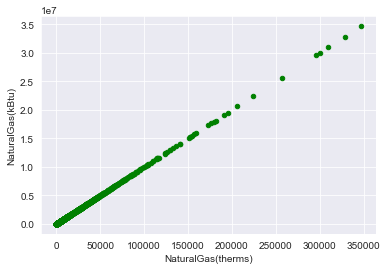

In [11]:
print("Natural Gas")
dataset.plot.scatter("NaturalGas(therms)", "NaturalGas(kBtu)", c="g")

Electricity


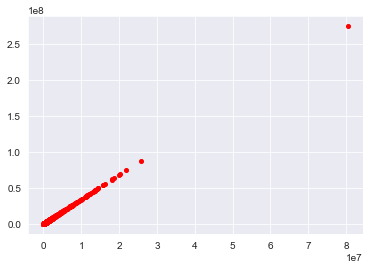

In [12]:
# Easy Linear Regression : x = kWh y = kBtu
print("Electricity")
plt.plot(dataset["Electricity(kWh)"], dataset["Electricity(kBtu)"], "ro", markersize=4)
plt.show()

In [13]:
print(
    "After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.")
dataset_v1 = dataset.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.


We tried to implement linear regression to verify that :
- the Electricity in kWh x 3.412 = Electricity in kBtu,
- the NaturalGas in Therms x 99.98 = NaturalGas in kBtu.


#### Manual Linear Regression

In [14]:
# Linear Regression "manually" / we transform the dataset into matrices to compute theta
X = np.matrix([np.ones(dataset.shape[0]), dataset["Electricity(kWh)"]]).T
Y = np.matrix(dataset["Electricity(kBtu)"]).T

C:\Users\athen\AppData\Local\Temp\ipykernel_3744\2136336263.py:2: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  X = np.matrix([np.ones(dataset.shape[0]), dataset["Electricity(kWh)"]]).T


In [15]:
np.set_printoptions(suppress=True)  # remove scientific notation
X[:10]

matrix([[     1.     , 239244.     ],
        [     1.     , 357008.1875 ],
        [     1.     ,  89109.89844],
        [     1.     , 631404.3125 ],
        [     1.     , 192884.0938 ],
        [     1.     , 154136.4063 ],
        [     1.     , 803639.6875 ],
        [     1.     , 857081.375  ],
        [     1.     , 403017.5    ],
        [     1.     ,  40037.80078]])

In [16]:
# Computing the exact value of the parameter theta
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

# displaying theta with a = slope ; and b = y-intercept
print(theta)

# we test Y = aX + b for X = 10
print(theta.item(0) + theta.item(1) * 10)

[[0.00971308]
 [3.412     ]]
34.129713041512716


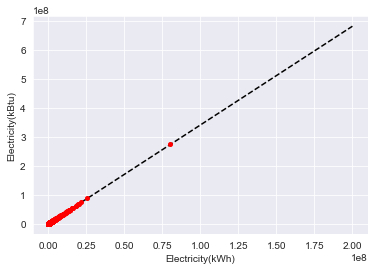

In [17]:
plt.xlabel("Electricity(kWh)")
plt.ylabel("Electricity(kBtu)")

x_min = 0
x_max = 200000000
y_min = theta.item(0)
y_max = theta.item(0) + x_max * theta.item(1)

plt.plot([x_min, x_max], [y_min, y_max], linestyle="--", c="#000000")
plt.plot(dataset["Electricity(kWh)"], dataset["Electricity(kBtu)"], "ro", markersize=4)

plt.show()

#### Automatic Linear Regression

In [18]:
# 0) Getting data and Sampling
from sklearn.linear_model import LinearRegression

X = dataset["Electricity(kWh)"]
y = dataset["Electricity(kBtu)"]  # target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# reshape to get 2D array instead of 1D array.
# values to get a numpy array instead of a pandas Series
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [19]:
X_train

array([[  77109.70313],
       [ 488099.1875 ],
       [1992345.25   ],
       ...,
       [ 169652.4063 ],
       [ 258357.9063 ],
       [ 158717.0938 ]])

In [20]:
# 1) Training Linear Regression and Evaluating
reg = LinearRegression().fit(X_train, y_train)
prediction_score = reg.score(X_test, y_test)
#print("Accuracy is : %.2f" % (100 * prediction_score))
print('Accuracy is : {:.0%}'.format(prediction_score))

# 2) Trying to predict a value
reg.predict([[10]])  # if X = 10 kWh then Y = 34.12 kBtu ;)

Accuracy is : 100%


array([[34.13025202]])

Electricity prediction


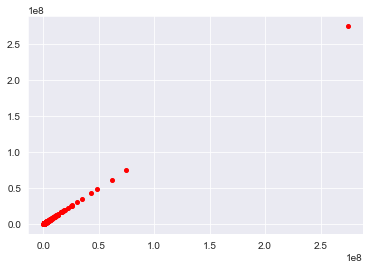

In [21]:
print("Electricity prediction")
plt.plot(reg.predict(X_test), y_test, "ro", markersize=4)
plt.show()

#### Conclusion :
This Linear Rregression was for training purposes.
We remove the redundant features like Electricity in kWh and NaturalGas in Therms.

Thanks to the correlation matrix below, we will be able to choose the features that will help our prediction model.

for column in dataset_v1.select_dtypes(['int32', 'float64']).columns:
    plt.figure(figsize=(12,6))
    plt.title('Distribution de ' + column)
    sns.histplot(data[column], bins=20)

### 2) Correlation Matrix

#### 2.1) Correlation between energy variables

In [22]:
all_energy_features = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)",
                       "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", "SteamUse(kBtu)", "Electricity(kBtu)",
                       "NaturalGas(kBtu)", "TotalGHGEmissions", "GHGEmissionsIntensity"]

In [23]:
# exploration : matrice corrélation et corrélation entre categorielles et quantitatives (GHGE corrélé avec var consom E (elctricity, steam etc)
# predict : consomation bat puis avec ca predire l'emission CO2
# 1) prediction consommation sur l'énergie puis predire CO2 (le + long le +complexe)
# categories batiments mal ecrites / numeriques incohérentes

We display here the correlation matrix without options to justify the display below.


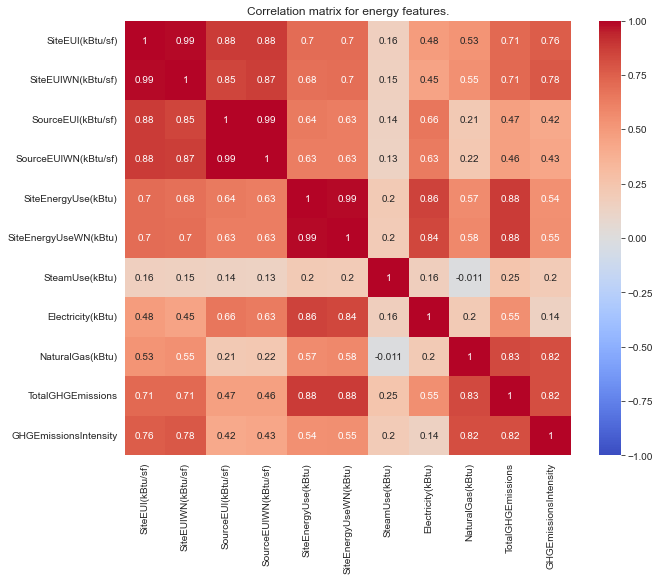

In [24]:
# we create a dataframe with all the energy features.
df_to_corr = dataset_v1[all_energy_features]

# we assign the type float to all the values of the matrix
df_to_corr = df_to_corr.astype(float)
corr_df = df_to_corr.corr(method='spearman')

print("We display here the correlation matrix without options to justify the display below.")
plt.figure(figsize=(10, 8))
plt.title('Correlation matrix for energy features.')
sns.heatmap(corr_df, annot=True, vmin=-1, cmap='coolwarm')
plt.show()

C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


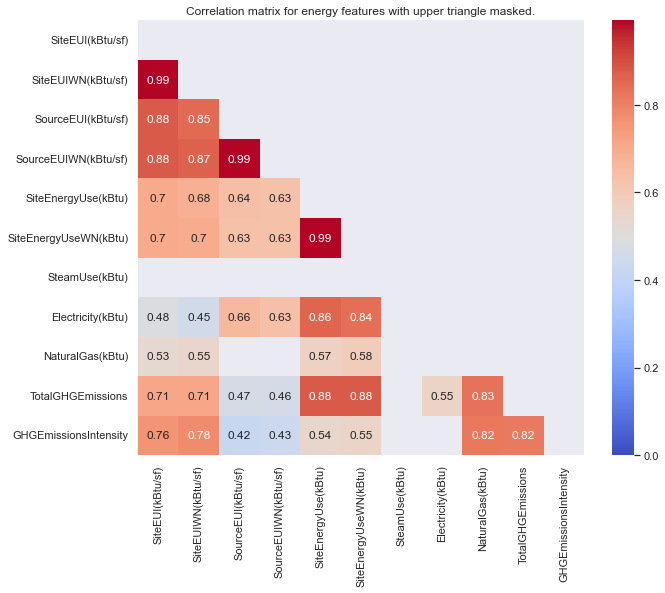

In [25]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=1)
plt.title('Correlation matrix for energy features with upper triangle masked.')

# to hide the upper triangle of the matrix
trimask = np.zeros_like(corr_df)
trimask[np.triu_indices_from(trimask)] = True
sns.heatmap(corr_df, annot=True, mask=trimask | (np.abs(corr_df) <= 0.4), vmin=0,
            cmap='coolwarm')  # we don't have negative correlations here

plt.show()

**Interpretation** :

- We can see a strong correlation between the variables.


**Conclusion** :
- We will drop the variables Weather Normalized,
- We drop the variable GHGEmissionsIntensity.

#### 2.2) Correlation matrix with all features

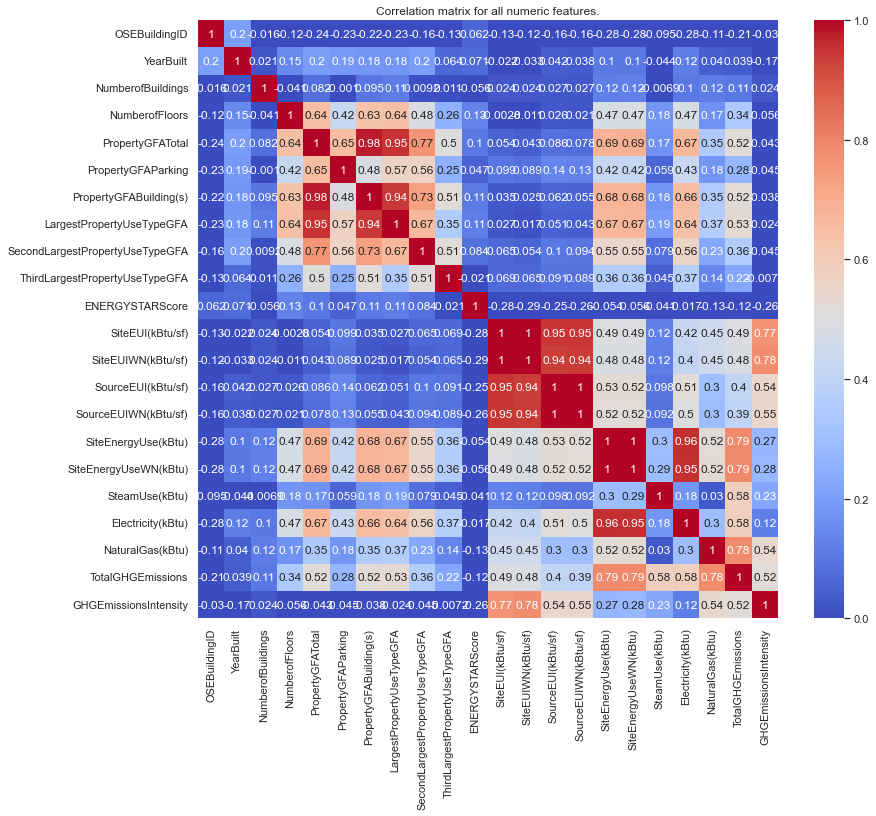

In [26]:
numeric_columns = dataset_v1.select_dtypes(include=['int64', 'float64']).columns
corr = dataset_v1[numeric_columns].corr()

plt.figure(figsize=(13, 11))
sns.set(font_scale=1)
plt.title('Correlation matrix for all numeric features.')

# to hide the upper triangle of the matrix
trimask = np.zeros_like(corr)
trimask[np.triu_indices_from(trimask)] = True
sns.heatmap(corr, annot=True, vmin=0, cmap='coolwarm')  # we don't have negative correlations here

plt.show()

dataset_v1.columns

In [27]:
print("ASK MENTOR INTERPRETATION CORR MATRIX")
# carac bat interess pour predirection / redtirer quand trop correlees entre elles

ASK MENTOR INTERPRETATION CORR MATRIX


**Interpretation** :

- We can see a strong correlation between the variables.


**Conclusion** :
- We will drop the variables Weather Normalized,
- We drop the variable GHGEmissionsIntensity.

In [28]:
correlated_features = ["SiteEUI(kBtu/sf)", 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)',
                       'SourceEUIWN(kBtu/sf)', "GHGEmissionsIntensity"]

In [29]:
dataset_v2 = dataset_v1.drop(columns=correlated_features, inplace=False)

### 3) Distribution of quantitative variables

#### 3.1) Boxplot per primary property type

In [30]:
dataset_v2.dtypes

OSEBuildingID                         int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                       category
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEnergyUse(kBtu)                 float64
SteamUse(kBtu)                      float64
Electricity(kBtu)                   float64
NaturalGas(kBtu)                

In [31]:
from functions import *

print("After removing outliers, we display boxplot per energy feature and per Primary Property Type.")
print(
    "We suppose that a K-12 School has different energy needed compared to a hospital, so the boxplot must represent that difference.")

data_plot = dataset_v2.copy()
data_plot.loc[data_plot["ENERGYSTARScore"] == -1] = np.nan

list_features_to_plot = data_plot.select_dtypes(include="number").columns.tolist()
list_features_to_plot.remove("OSEBuildingID")

After removing outliers, we display boxplot per energy feature and per Primary Property Type.
We suppose that a K-12 School has different energy needed compared to a hospital, so the boxplot must represent that difference.


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


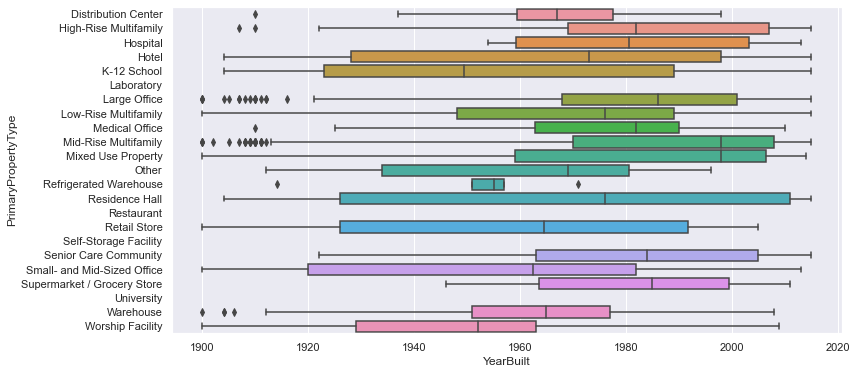

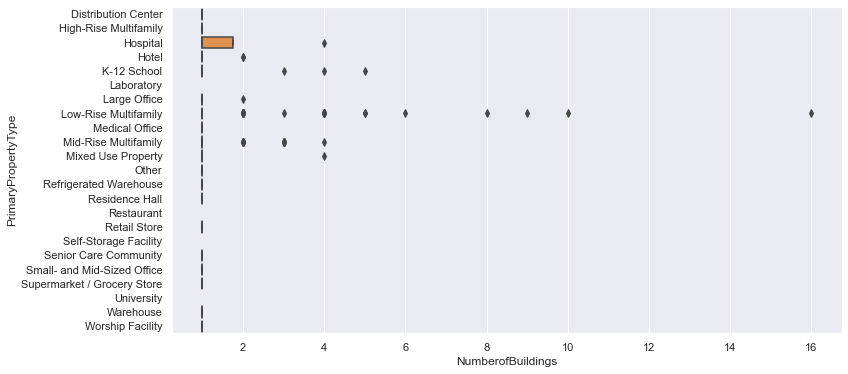

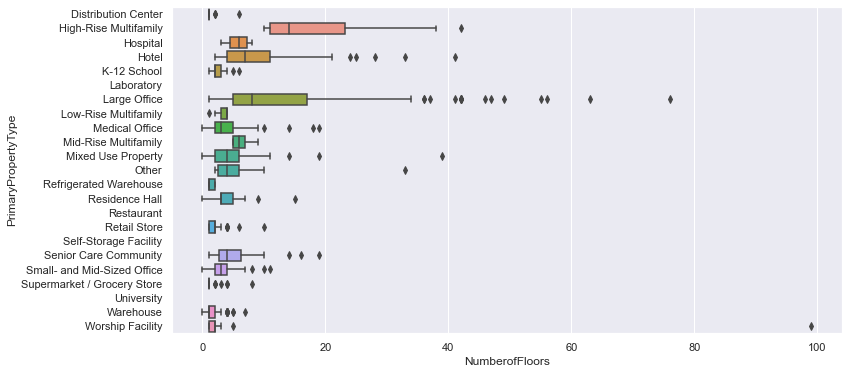

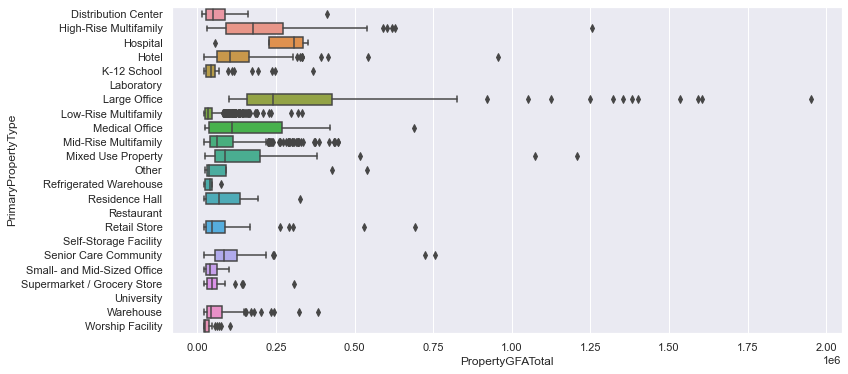

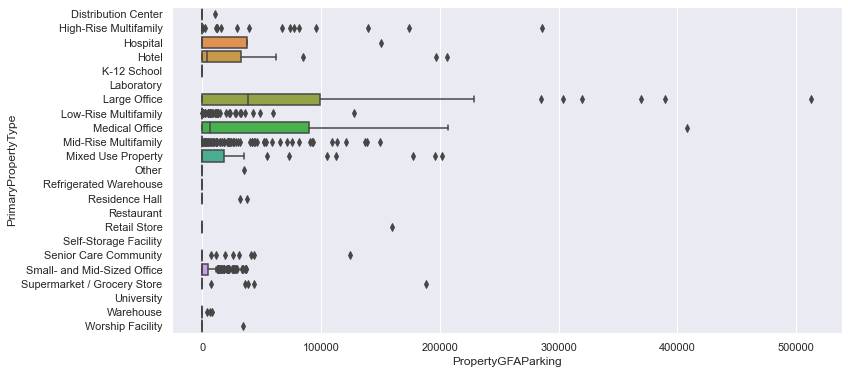

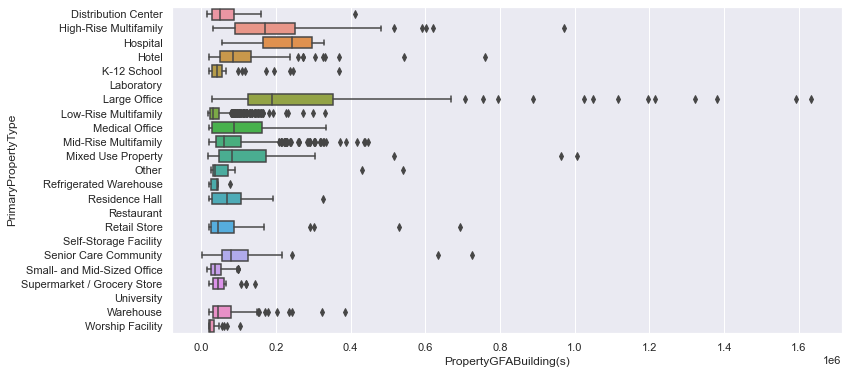

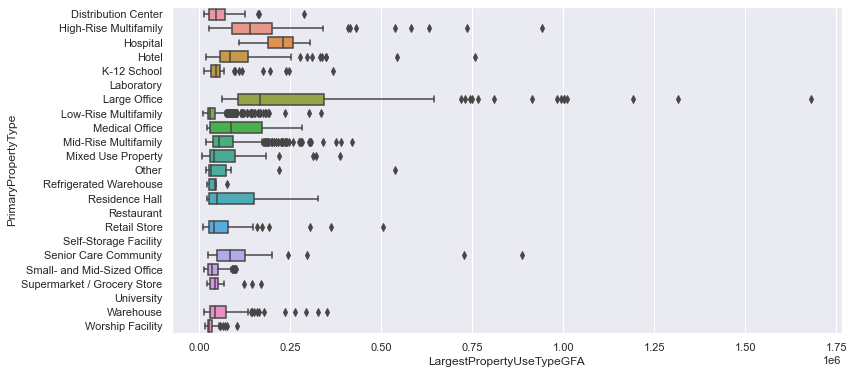

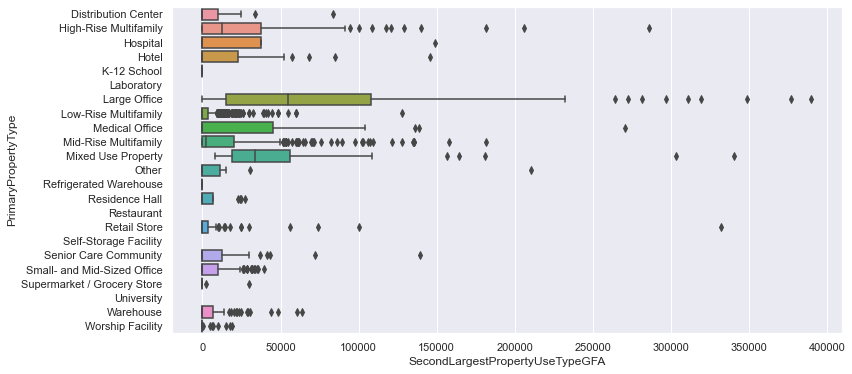

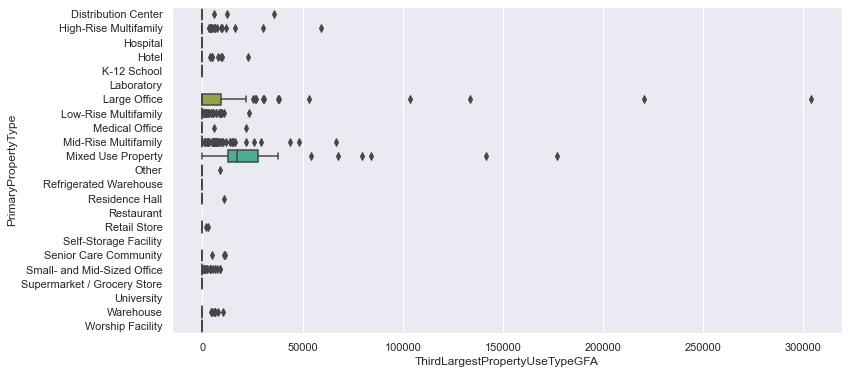

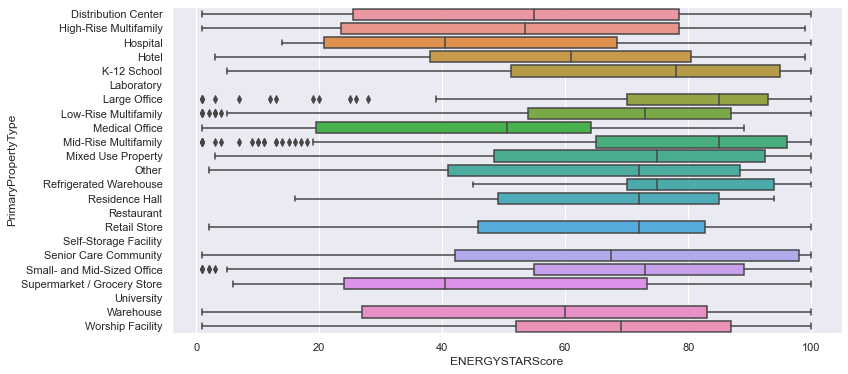

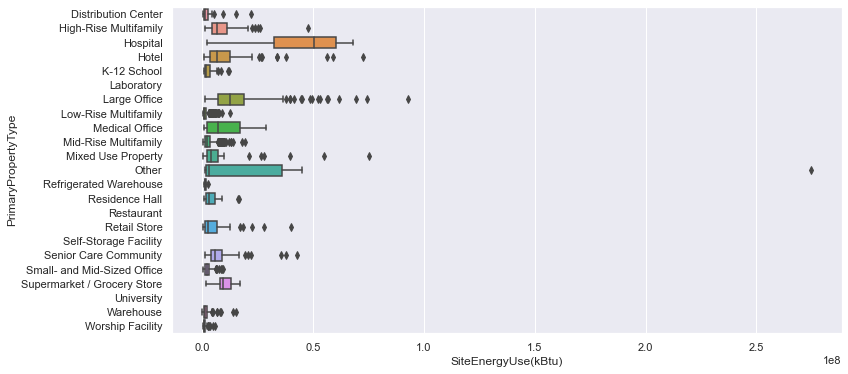

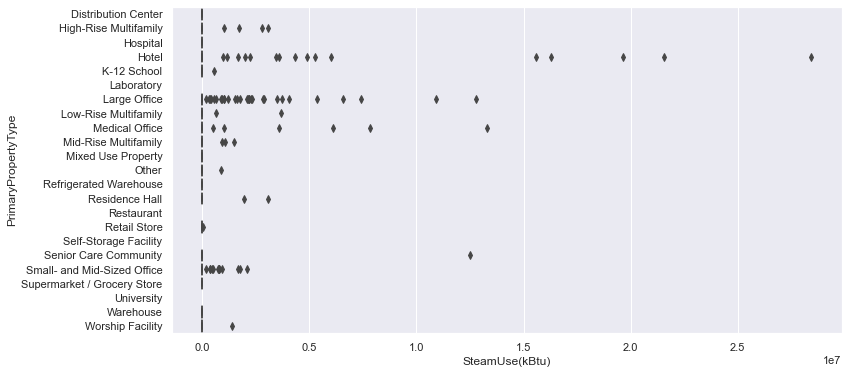

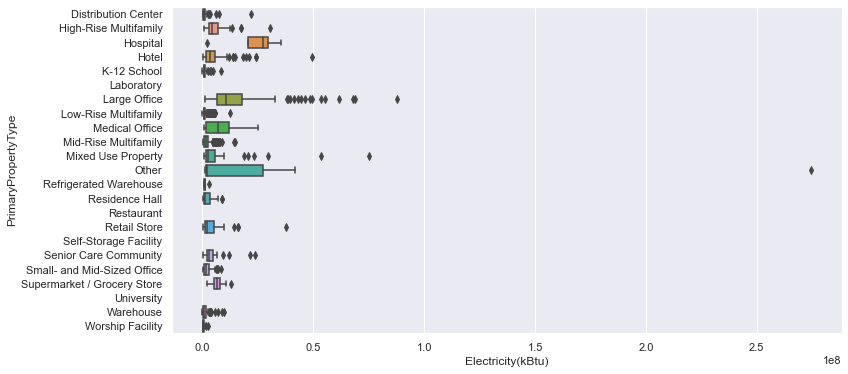

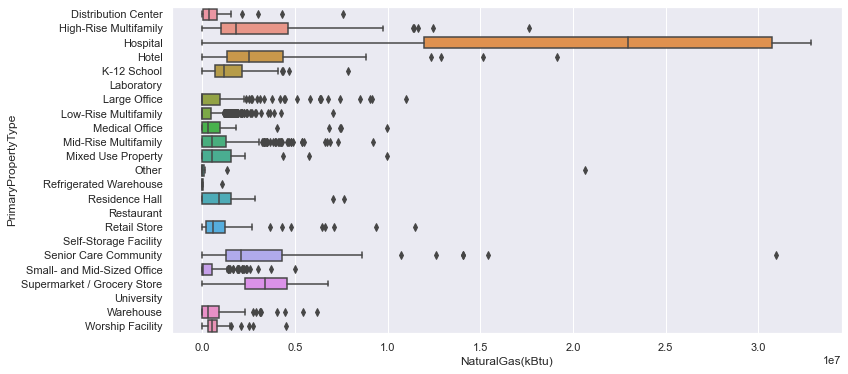

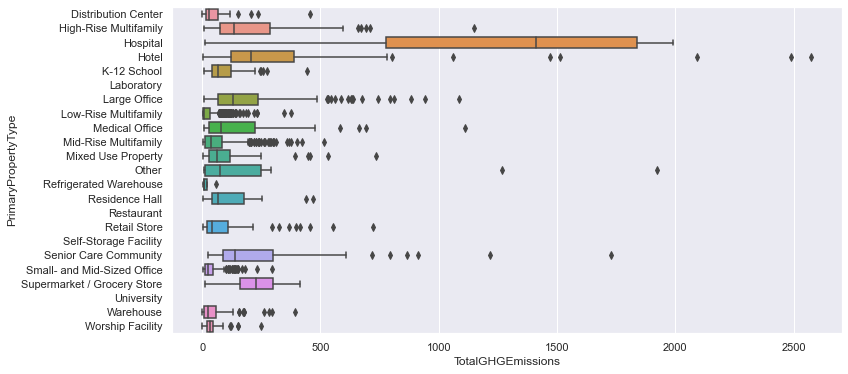

In [32]:
display_boxplot_per_feature(data_plot, list_features_to_plot, "PrimaryPropertyType")

#### 3.2) Histograms

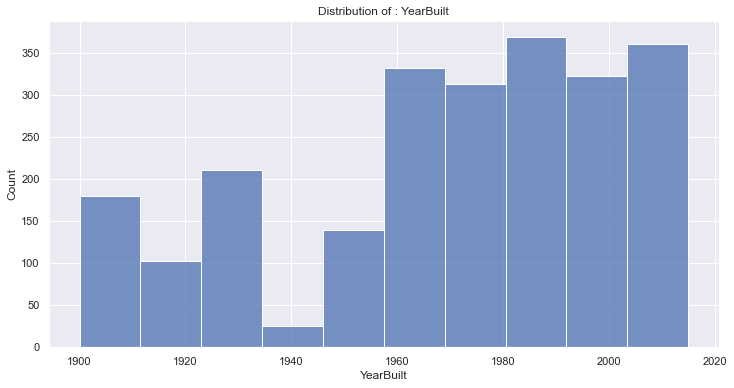

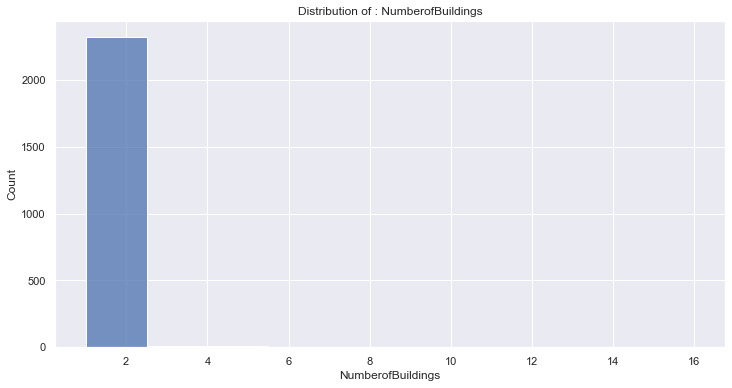

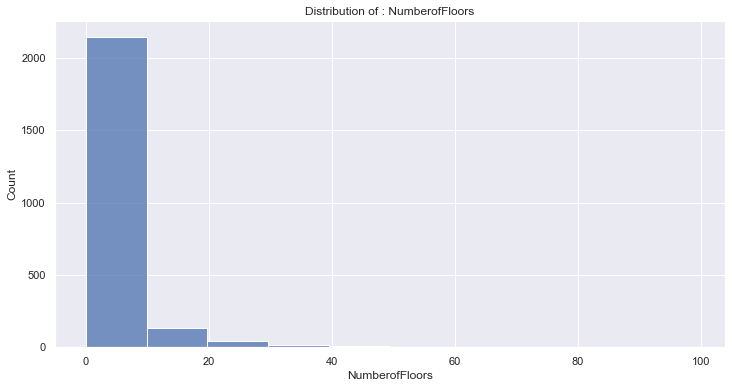

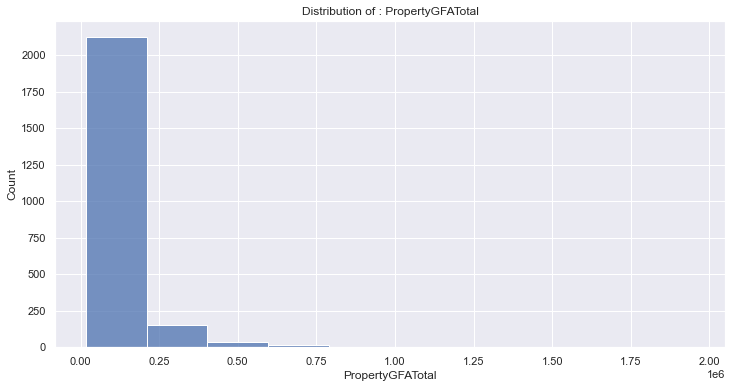

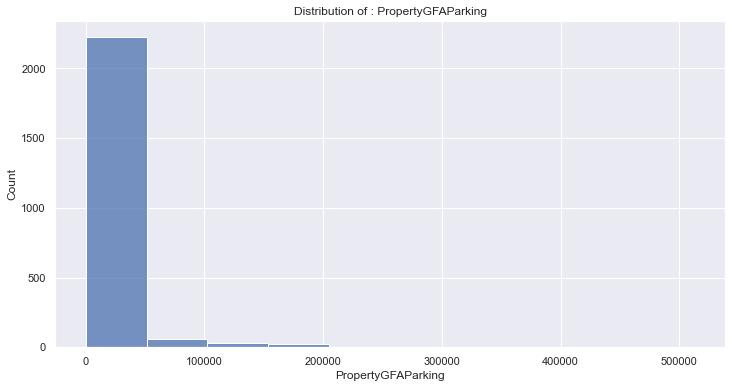

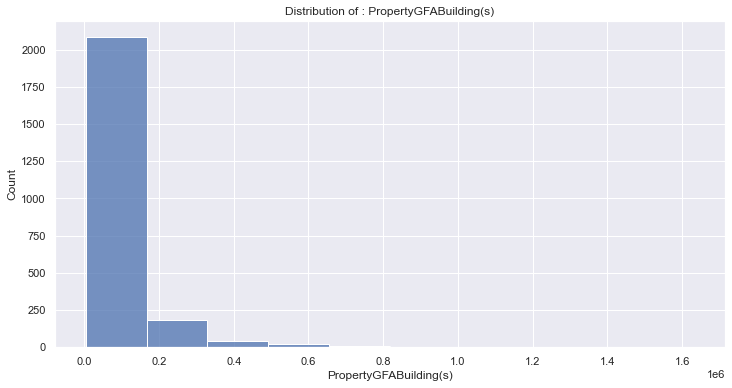

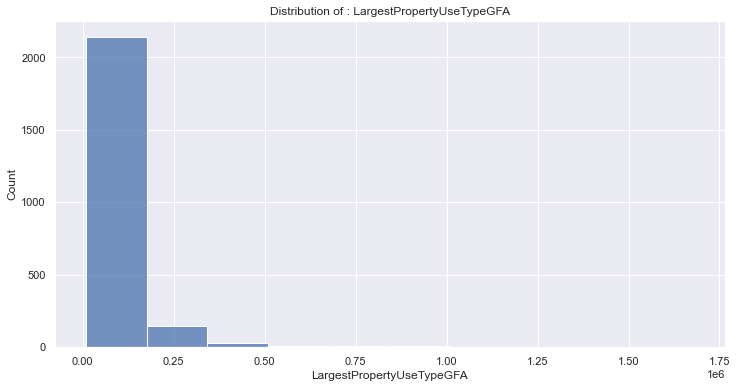

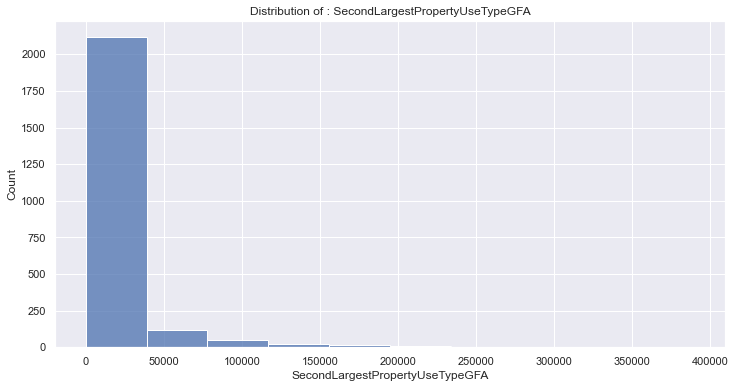

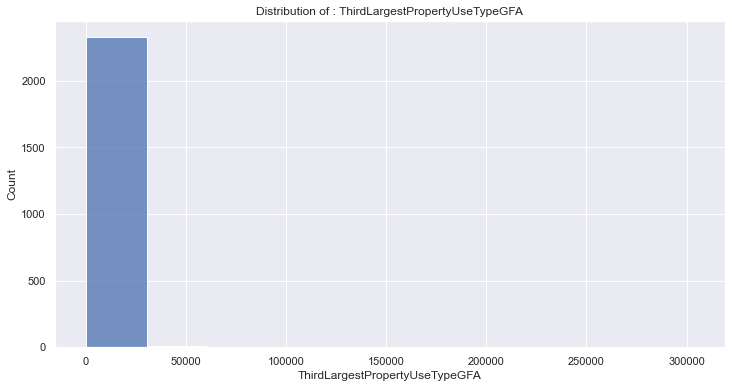

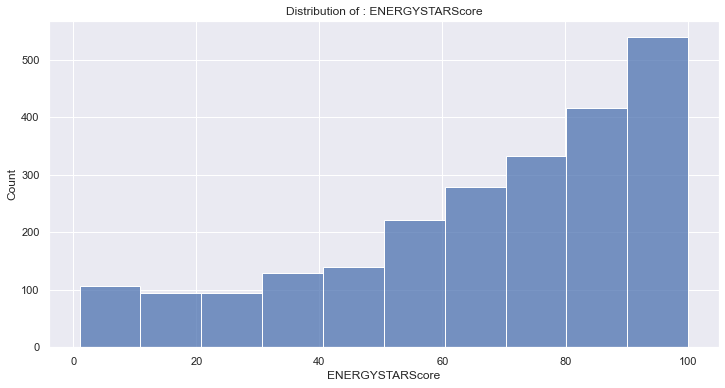

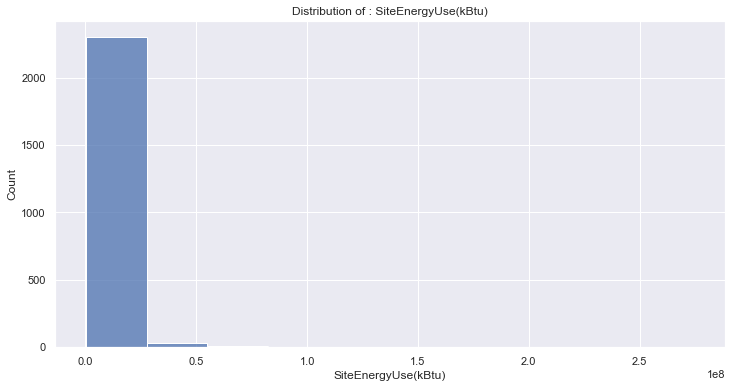

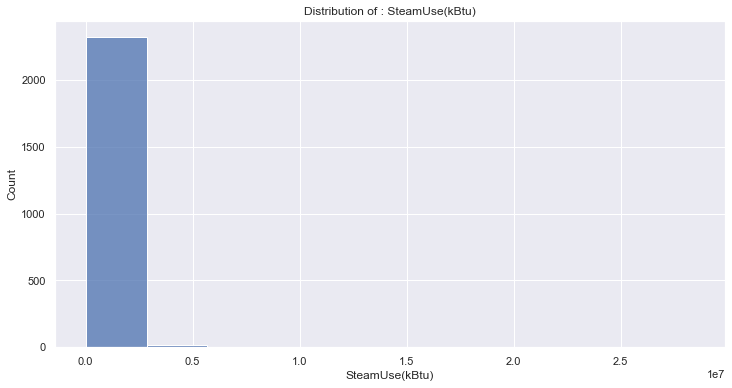

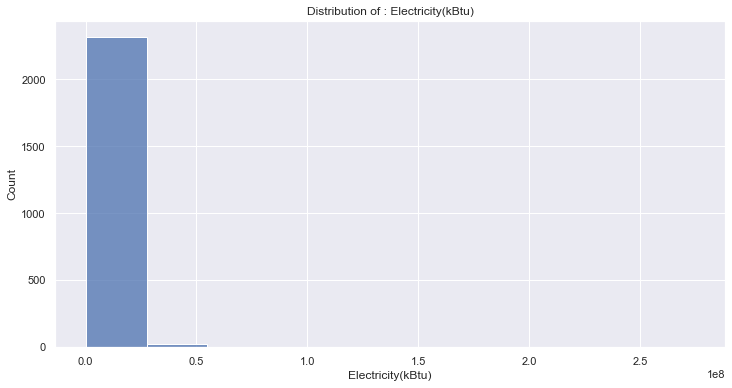

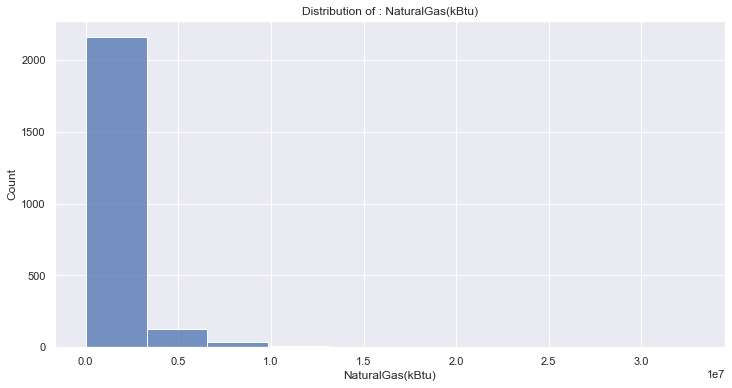

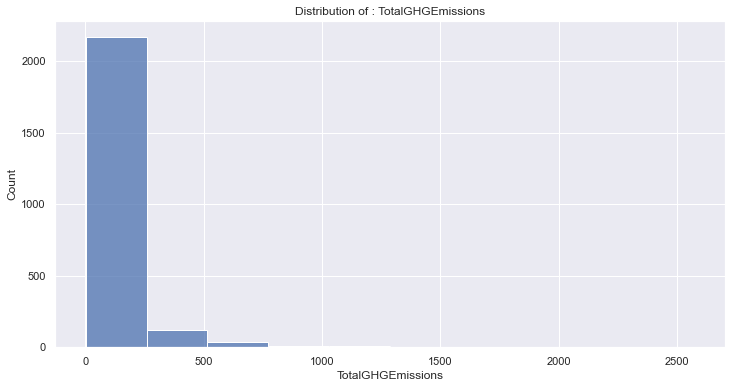

In [33]:
display_distribution_per_feature(data_plot, list_features_to_plot, 10)

In [34]:
dataset_v2.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

#### 3.3) Distribution

In [35]:
dataset_v2.dtypes

OSEBuildingID                         int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                       category
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEnergyUse(kBtu)                 float64
SteamUse(kBtu)                      float64
Electricity(kBtu)                   float64
NaturalGas(kBtu)                

C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

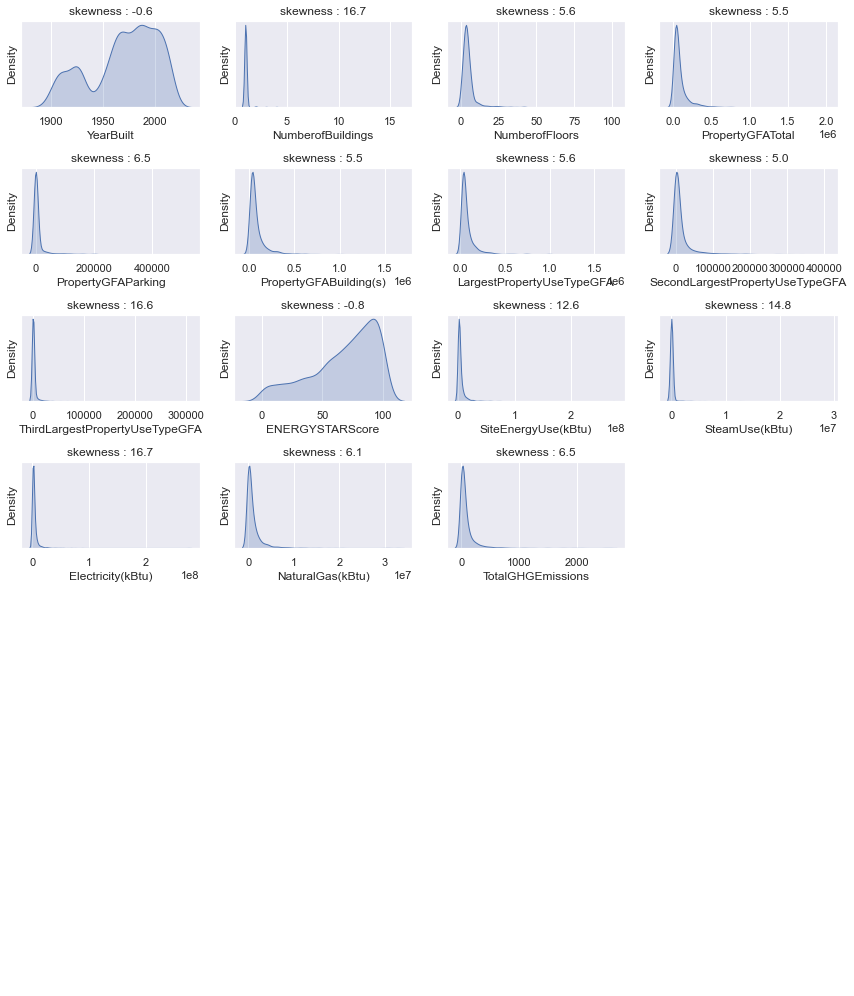

In [36]:
features_for_prediction = ["YearBuilt", "CouncilDistrictCode", "Neighborhood", "NumberofBuildings", "NumberofFloors",
                           "BuildingType", "PrimaryPropertyType", "LargestPropertyUseType",
                           "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "PropertyGFABuilding(s)",
                           "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA",
                           "ThirdLargestPropertyUseTypeGFA"]

densite(data_plot[list_features_to_plot])

### 4) Logarithmic transformation of the variables to predict

#### 4.1) Log Graphs ??

In [37]:
print("We check the effect of a log transformation on the variable we want to predict.")
#all_log_transformations = compute_log_for_feature(dataset_v2, "SiteEnergyUse(kBtu)")
#log_distribution(all_log_transformations)

We check the effect of a log transformation on the variable we want to predict.


#### 4.2) Log transformation for the features to predict

In [38]:
features_to_predict = [
    "SiteEnergyUse(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kBtu)",
    "NaturalGas(kBtu)",
    "TotalGHGEmissions"]

print(features_to_predict)

['SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']


In [40]:
print("These are the features that need a transformation :")
skew_features = get_features_skewness(dataset_v2)
print(skew_features)

These are the features that need a transformation :
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']


Before :


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

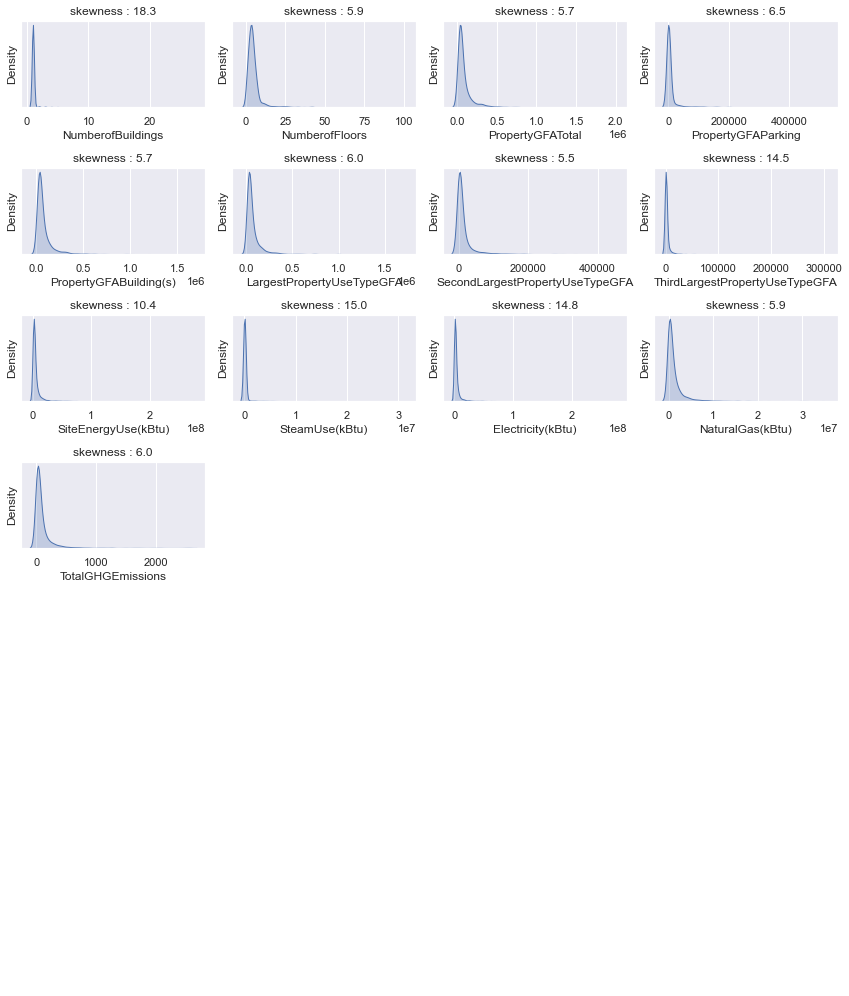

In [41]:
print("Before :")
densite(dataset_v2[skew_features])

In [42]:
print("Trying different log transformations :")
test_log = compute_log_effect_on_skewness(dataset_v2, skew_features)
display(test_log)

Trying different log transformations :


C:\Users\athen\Documents\Scolarité\Alternance\OC projets\P4_El_Gharbi_Oumeima\P4_Data_Science_OpenClassrooms\functions.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_log_transformations.append({"feature": [feature],


TypeError: Can only append a dict if ignore_index=True

In [ ]:
dataset_v3 = log_transformation(dataset_v2, skew_features)
display(dataset_v3)

In [ ]:
log_skew_features = ["Log-{}".format(feature) for feature in skew_features]

In [ ]:
log_skew_features

In [ ]:
dataset_v3

In [ ]:
print("After :")
densite(dataset_v3[log_skew_features])

### 5) Saving cleaned dataset

In [ ]:
# We reset the index
final_dataset = dataset_v3.reset_index(drop=True)

# Save
export_path = "./dataset/cleaned/"
export_filename = "2016_Building_Energy_Prediction.csv"
final_dataset.to_csv("{}{}".format(export_path, export_filename), index=False)